In [0]:
import pandas as pd
# Read data.  This data represents the cumulative known cases to date (https://covidtracking.com/about-data/faq)
url = 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])

In [2]:
df.head(5)

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,262.0,d15bb8087806f8dded75fb6165d7bed1bcface44,2020-05-03T20:00:00Z,9.0,NaN,21578.0,21578.0,21578.0,2,0.0,0.0,176.0,3.0,179.0
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,403.0,NaN,242.0,NaN,aa4e1102894dd9528461e4d910fab397cc40d31b,2020-05-03T20:00:00Z,290.0,1035.0,92500.0,92500.0,92500.0,1,2.0,12.0,0.0,291.0,291.0
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,NaN,NaN,20.0,88.0,1999.0,6b15aab296af49161db3f9fc69eef7c6ca244994,2020-05-03T20:00:00Z,76.0,427.0,52890.0,52890.0,52890.0,5,3.0,13.0,1249.0,59.0,1308.0
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ccae2e571ac93c5836a22158f57c12313127810d,2020-05-03T20:00:00Z,0.0,NaN,57.0,57.0,57.0,60,0.0,0.0,0.0,0.0,0.0
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,282.0,NaN,192.0,NaN,1597.0,c687661dcf3f892bcc23c38ddcb46fe809b006f1,2020-05-03T20:00:00Z,362.0,1348.0,81119.0,81119.0,81119.0,4,14.0,9.0,2846.0,276.0,3122.0


In [3]:
# Drop total, posNeg, and hospitalized columns as they are redundant
# Drop other columns that will not be used
#df_drop = df.drop(columns = [6, 7, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23])
df_drop = df.drop(columns = ['inIcuCurrently', 'inIcuCumulative', 
                             'onVentilatorCurrently', 'onVentilatorCumulative', 
                             'hash', 'dateChecked', 'hospitalized', 'total', 
                             'posNeg', 'fips', 'deathIncrease', 
                             'hospitalizedIncrease', 'negativeIncrease', 
                             'positiveIncrease', 'totalTestResultsIncrease'])
df_drop.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults
date,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0


In [4]:
# Create new features
# Divide positive by totalTestResults to get positive_percent
df_drop["percent_positive"] = ""
df_drop["percent_positive"] = 100*df_drop["positive"]/df_drop["totalTestResults"]
df_drop.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive
date,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0,8.351351
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0,6.487049
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0,0.000000
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0,10.651019


In [5]:
# Divide hospitalized by positive to get hospitalized_percent
import numpy as np
df_drop["hospitalized_percent"] = ""
df_drop["hospitalized_percent"] = np.nanmax(df_drop[['hospitalizedCurrently','hospitalizedCumulative']], axis=1)
df_drop["hospitalized_percent"] = 100*df_drop["hospitalized_percent"]/df_drop["positive"]
df_drop.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: All-NaN axis encountered
  This is separate from the ipykernel package so we can avoid doing imports until


,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent
date,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441,3.260870
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0,8.351351,13.398058
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0,6.487049,12.445351
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0,0.000000,NaN
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0,10.651019,15.601852


In [6]:
# Divide recovered by positive to get recovered_percent
df_drop["recovered_percent"] = ""
df_drop["recovered_percent"] = 100*df_drop["recovered"]/df_drop["positive"]
df_drop.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent,recovered_percent
date,,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441,3.260870,71.195652
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0,8.351351,13.398058,NaN
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0,6.487049,12.445351,58.262897
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0,0.000000,NaN,NaN
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0,10.651019,15.601852,18.483796


In [7]:
# Divide death by positive to get death_percent
df_drop["death_percent"] = ""
df_drop["death_percent"] = 100*df_drop["death"]/df_drop["positive"]
df_drop.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent,recovered_percent,death_percent
date,,,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441,3.260870,71.195652,2.445652
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0,8.351351,13.398058,NaN,3.754045
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0,6.487049,12.445351,58.262897,2.215098
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0,0.000000,NaN,NaN,NaN
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0,10.651019,15.601852,18.483796,4.189815


In [8]:
# Fetch the latest state population data (nst-est2019-01.csv)
from google.colab import files
uploaded = files.upload()

Saving nst-est2019-01.csv to nst-est2019-01.csv


In [9]:
# Load latest state population data
import io
df_state_pop = pd.read_csv(io.StringIO(uploaded['nst-est2019-01.csv'].decode('utf-8')))
df_state_pop["Population"] = pd.to_numeric(df_state_pop["Population"])
df_state_pop.head()

,State,Population
0,AK,731545.0
1,AL,4903185.0
2,AR,3017804.0
3,AS,NaN
4,AZ,7278717.0


In [10]:
# Add column of state populations (population) to df_drop_total_posNeg
# Need to sort rows by state using index numbering from state_list

df_drop["population"] = ""

for i in range(len(df_drop)):
  for index in range(len(df_state_pop)):
    if df_drop.iloc[i, 0] == df_state_pop.iloc[index, 0]:
      df_drop.iloc[i, 13] = df_state_pop.iloc[index, 1]

df_drop[["population"]] = df_drop["population"].apply(pd.to_numeric)

df_drop.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent,recovered_percent,death_percent,population
date,,,,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441,3.260870,71.195652,2.445652,731545.0
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0,8.351351,13.398058,NaN,3.754045,4903185.0
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0,6.487049,12.445351,58.262897,2.215098,3017804.0
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0,0.000000,NaN,NaN,NaN,NaN
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0,10.651019,15.601852,18.483796,4.189815,7278717.0


In [11]:
# Normalize positive to state population
df_drop["positive_norm"] = ""
df_drop["positive_norm"] = df_drop["positive"]/df_drop["population"]
df_drop.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent,recovered_percent,death_percent,population,positive_norm
date,,,,,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441,3.260870,71.195652,2.445652,731545.0,0.000503
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0,8.351351,13.398058,NaN,3.754045,4903185.0,0.001576
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0,6.487049,12.445351,58.262897,2.215098,3017804.0,0.001137
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0,0.000000,NaN,NaN,NaN,NaN,NaN
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0,10.651019,15.601852,18.483796,4.189815,7278717.0,0.001187


In [12]:
# Normalize hospitalized to state population
df_drop["hospitalized_norm"] = ""
df_drop["hospitalized_norm"] = np.nanmax(df_drop[['hospitalizedCurrently','hospitalizedCumulative']], axis=1)
df_drop["hospitalized_norm"] = df_drop["hospitalized_norm"]/df_drop["population"]
df_drop.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN axis encountered
  


,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent,recovered_percent,death_percent,population,positive_norm,hospitalized_norm
date,,,,,,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441,3.260870,71.195652,2.445652,731545.0,0.000503,0.000016
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0,8.351351,13.398058,NaN,3.754045,4903185.0,0.001576,0.000211
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0,6.487049,12.445351,58.262897,2.215098,3017804.0,0.001137,0.000141
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0,10.651019,15.601852,18.483796,4.189815,7278717.0,0.001187,0.000185


In [13]:
# Normalize recovered to state population
df_drop["recovered_norm"] = ""
df_drop["recovered_norm"] = df_drop["recovered"]/df_drop["population"]
df_drop.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent,recovered_percent,death_percent,population,positive_norm,hospitalized_norm,recovered_norm
date,,,,,,,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441,3.260870,71.195652,2.445652,731545.0,0.000503,0.000016,0.000358
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0,8.351351,13.398058,NaN,3.754045,4903185.0,0.001576,0.000211,NaN
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0,6.487049,12.445351,58.262897,2.215098,3017804.0,0.001137,0.000141,0.000662
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0,10.651019,15.601852,18.483796,4.189815,7278717.0,0.001187,0.000185,0.000219


In [14]:
# Normalize death to state population
df_drop["death_norm"] = ""
df_drop["death_norm"] = df_drop["death"]/df_drop["population"]
df_drop.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent,recovered_percent,death_percent,population,positive_norm,hospitalized_norm,recovered_norm,death_norm
date,,,,,,,,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441,3.260870,71.195652,2.445652,731545.0,0.000503,0.000016,0.000358,0.000012
2020-05-03,AL,7725.0,84775.0,NaN,NaN,1035.0,NaN,290.0,92500.0,8.351351,13.398058,NaN,3.754045,4903185.0,0.001576,0.000211,NaN,0.000059
2020-05-03,AR,3431.0,49459.0,NaN,100.0,427.0,1999.0,76.0,52890.0,6.487049,12.445351,58.262897,2.215098,3017804.0,0.001137,0.000141,0.000662,0.000025
2020-05-03,AS,0.0,57.0,NaN,NaN,NaN,NaN,0.0,57.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-03,AZ,8640.0,72479.0,NaN,732.0,1348.0,1597.0,362.0,81119.0,10.651019,15.601852,18.483796,4.189815,7278717.0,0.001187,0.000185,0.000219,0.000050


In [15]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3321 entries, 2020-05-03 to 2020-01-22
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3321 non-null   object 
 1   positive                3306 non-null   float64
 2   negative                3140 non-null   float64
 3   pending                 677 non-null    float64
 4   hospitalizedCurrently   1191 non-null   float64
 5   hospitalizedCumulative  1239 non-null   float64
 6   recovered               1037 non-null   float64
 7   death                   2594 non-null   float64
 8   totalTestResults        3319 non-null   float64
 9   percent_positive        3275 non-null   float64
 10  hospitalized_percent    1870 non-null   float64
 11  recovered_percent       1037 non-null   float64
 12  death_percent           2541 non-null   float64
 13  population              3125 non-null   float64
 14  positive_norm         

In [16]:
# Get the unique values of 'state' column 
state_list = df.state.unique() 
state_list

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [0]:
#create a data frame dictionary to store the state data frames
df_state_dict = {elem : pd.DataFrame for elem in state_list}

for key in df_state_dict.keys():
    df_state_dict[key] = df_drop[:][df_drop.state == key]


In [18]:
df_state_dict['AK'].head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent,recovered_percent,death_percent,population,positive_norm,hospitalized_norm,recovered_norm,death_norm
date,,,,,,,,,,,,,,,,,,
2020-05-03,AK,368.0,21210.0,NaN,12.0,NaN,262.0,9.0,21578.0,1.705441,3.260870,71.195652,2.445652,731545.0,0.000503,0.000016,0.000358,0.000012
2020-05-02,AK,365.0,21034.0,NaN,10.0,NaN,261.0,9.0,21399.0,1.705687,2.739726,71.506849,2.465753,731545.0,0.000499,0.000014,0.000357,0.000012
2020-05-01,AK,364.0,19961.0,NaN,25.0,NaN,254.0,9.0,20325.0,1.790898,6.868132,69.780220,2.472527,731545.0,0.000498,0.000034,0.000347,0.000012
2020-04-30,AK,355.0,18764.0,NaN,19.0,NaN,252.0,9.0,19119.0,1.856792,5.352113,70.985915,2.535211,731545.0,0.000485,0.000026,0.000344,0.000012
2020-04-29,AK,355.0,18764.0,NaN,14.0,NaN,240.0,9.0,19119.0,1.856792,3.943662,67.605634,2.535211,731545.0,0.000485,0.000019,0.000328,0.000012


In [19]:
df_state_dict['CA'].head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,recovered,death,totalTestResults,percent_positive,hospitalized_percent,recovered_percent,death_percent,population,positive_norm,hospitalized_norm,recovered_norm,death_norm
date,,,,,,,,,,,,,,,,,,
2020-05-03,CA,53616.0,662135.0,NaN,4734.0,NaN,NaN,2215.0,715751.0,7.490873,8.829454,NaN,4.131229,39512223.0,0.001357,0.000120,NaN,0.000056
2020-05-02,CA,52197.0,634606.0,NaN,4722.0,NaN,NaN,2171.0,686803.0,7.599996,9.046497,NaN,4.159243,39512223.0,0.001321,0.000120,NaN,0.000055
2020-05-01,CA,50442.0,604543.0,NaN,4706.0,NaN,NaN,2073.0,654985.0,7.701245,9.329527,NaN,4.109671,39512223.0,0.001277,0.000119,NaN,0.000052
2020-04-30,CA,48917.0,576420.0,NaN,4981.0,NaN,NaN,1982.0,625337.0,7.822502,10.182554,NaN,4.051761,39512223.0,0.001238,0.000126,NaN,0.000050
2020-04-29,CA,46500.0,556639.0,NaN,5011.0,NaN,NaN,1887.0,603139.0,7.709666,10.776344,NaN,4.058065,39512223.0,0.001177,0.000127,NaN,0.000048


In [0]:
from matplotlib import pyplot as plt

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

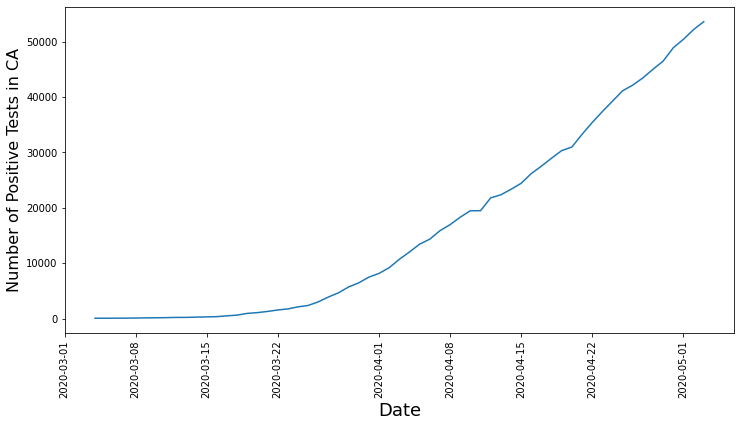

In [21]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].positive)
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of Positive Tests in CA', fontsize=16)
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

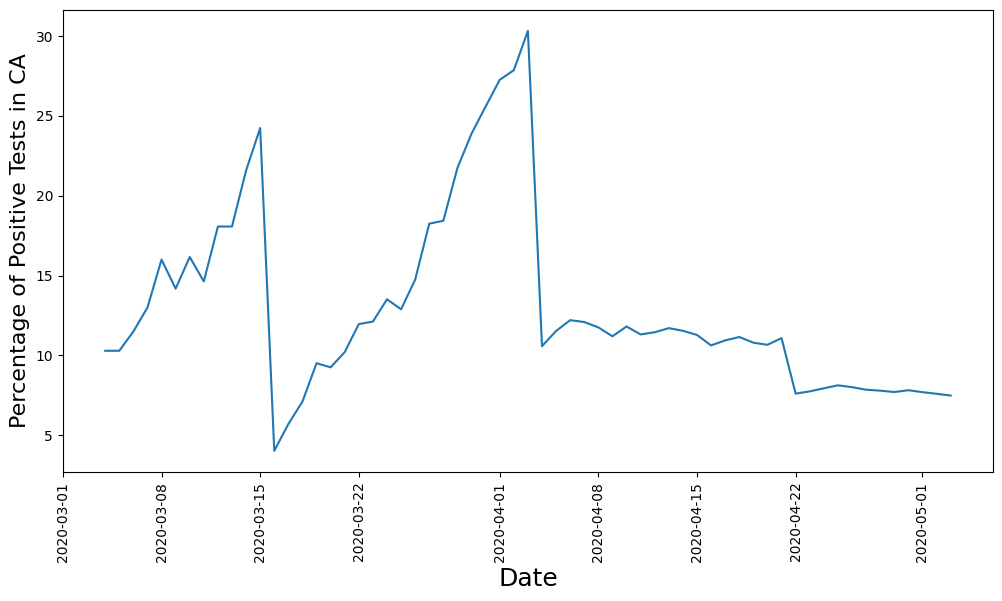

In [22]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].percent_positive)
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percentage of Positive Tests in CA', fontsize=16)
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

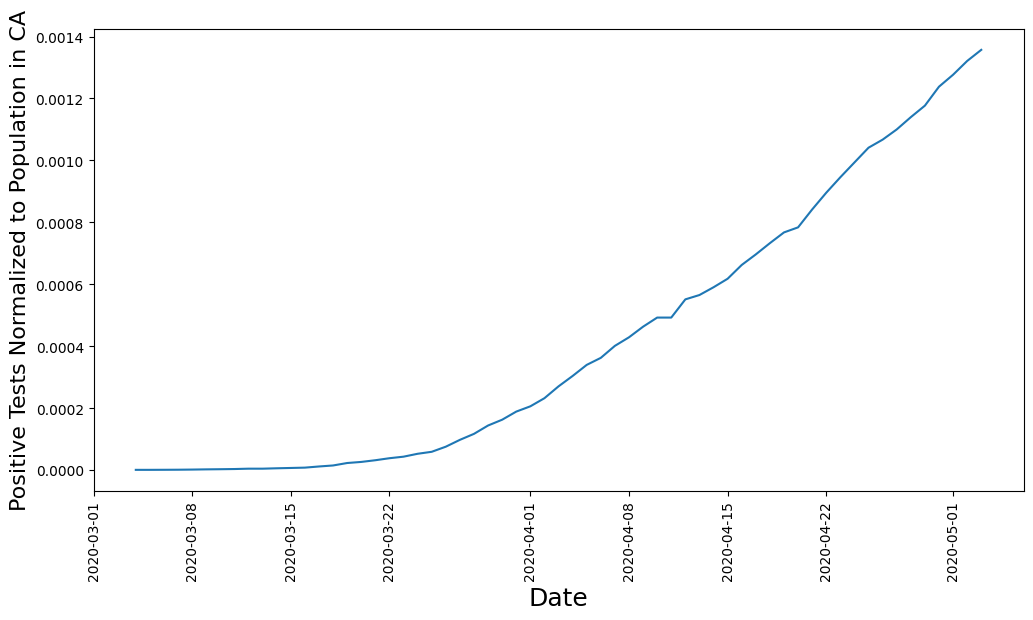

In [23]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].positive_norm)
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Positive Tests Normalized to Population in CA', fontsize=16)
plt.show()

<Figure size 640x480 with 0 Axes>

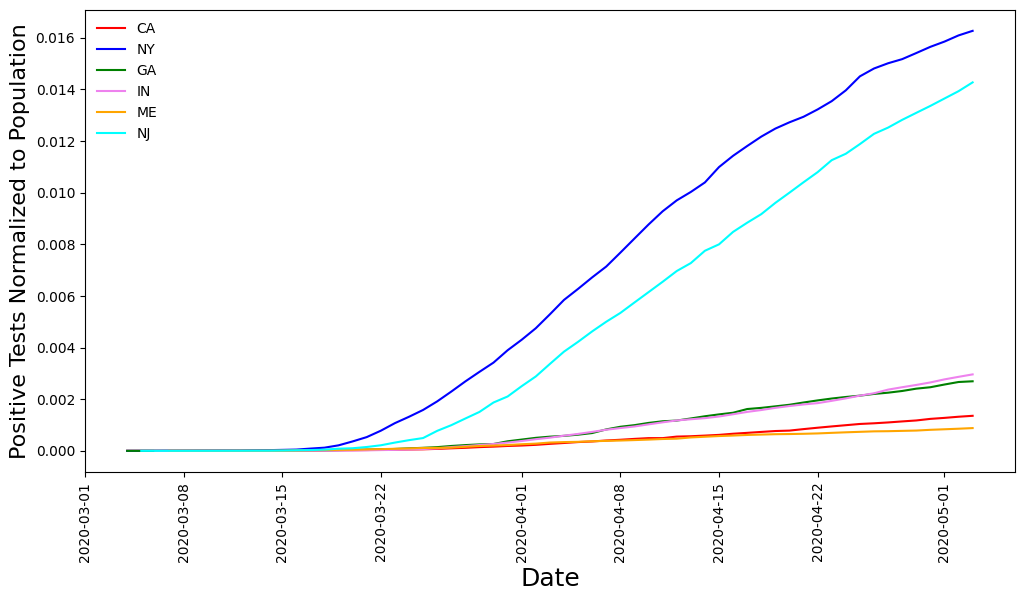

In [24]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].positive_norm, color="red", label="CA")
plt.plot(df_state_dict['NY'].positive_norm, color="blue", label="NY")
plt.plot(df_state_dict['GA'].positive_norm, color="green", label="GA")
plt.plot(df_state_dict['IN'].positive_norm, color="violet", label="IN")
plt.plot(df_state_dict['ME'].positive_norm, color="orange", label="ME")
plt.plot(df_state_dict['NJ'].positive_norm, color="cyan", label="NJ")
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Positive Tests Normalized to Population', fontsize=16)
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

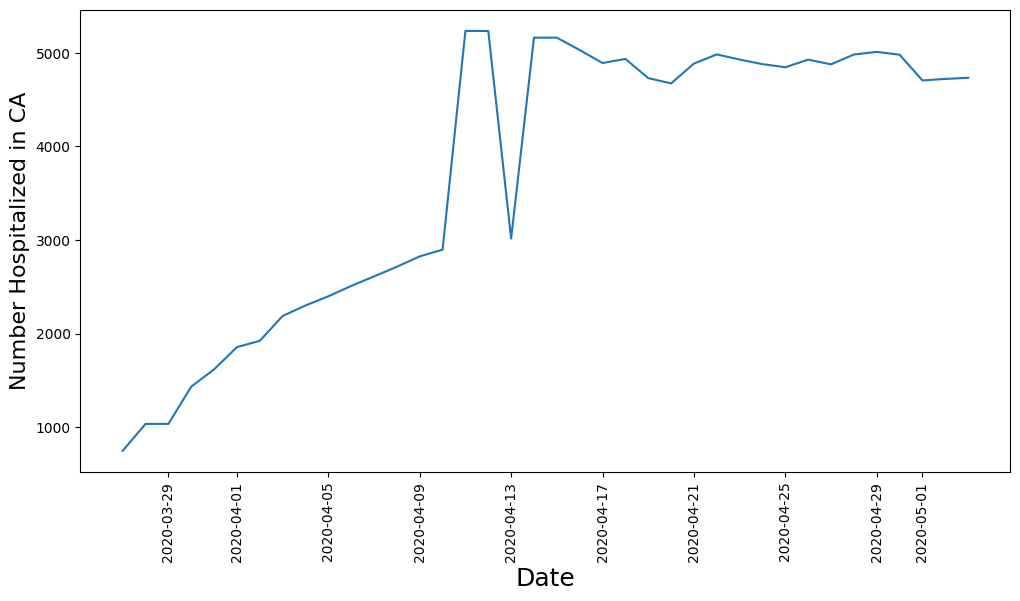

In [25]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].hospitalizedCurrently)
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number Hospitalized in CA', fontsize=16)
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

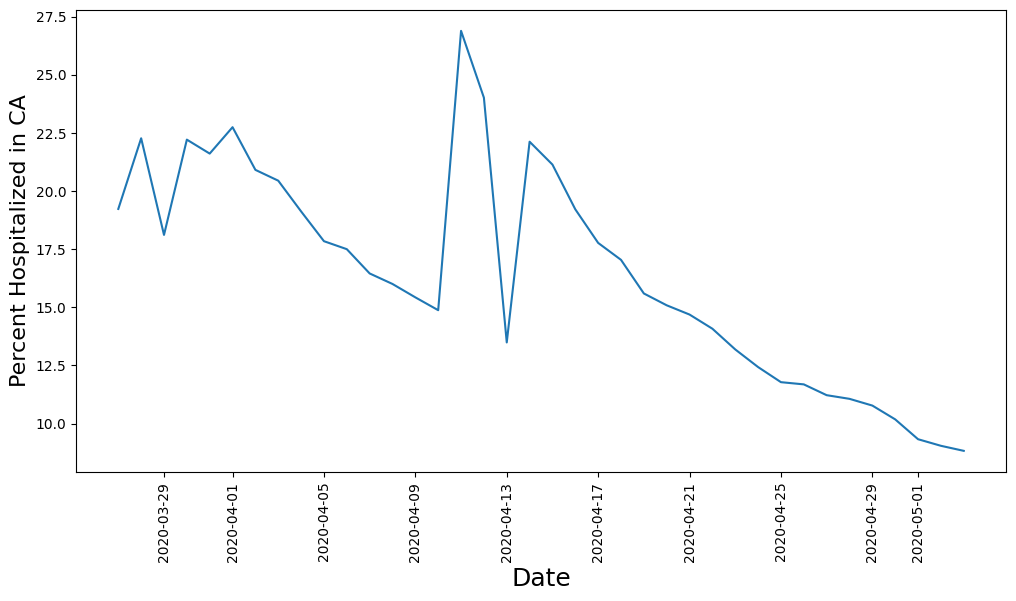

In [26]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].hospitalized_percent)
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percent Hospitalized in CA', fontsize=16)
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

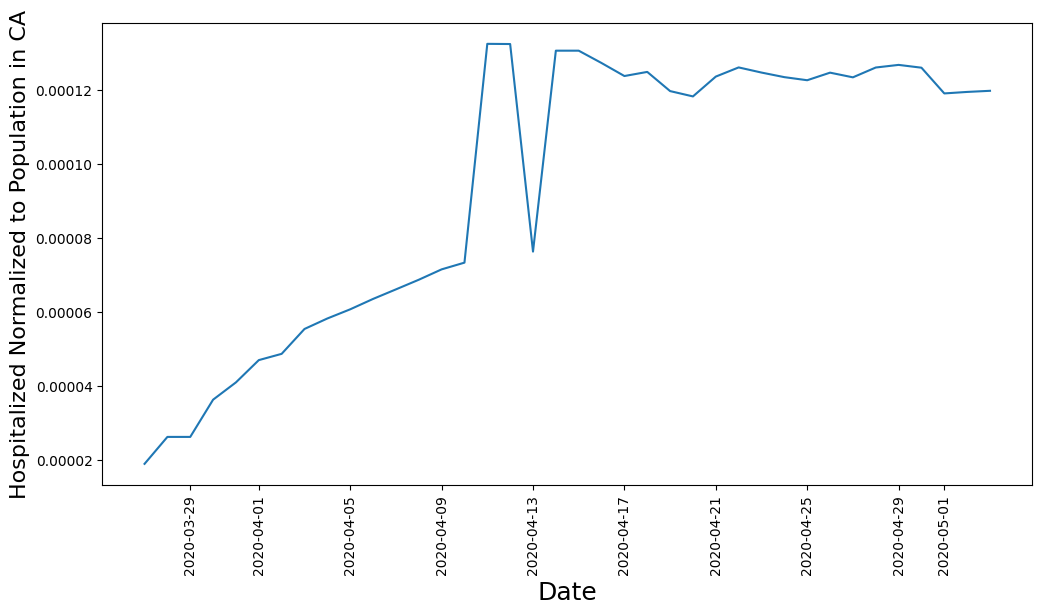

In [27]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].hospitalized_norm)
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Hospitalized Normalized to Population in CA', fontsize=16)
plt.show()

<Figure size 640x480 with 0 Axes>

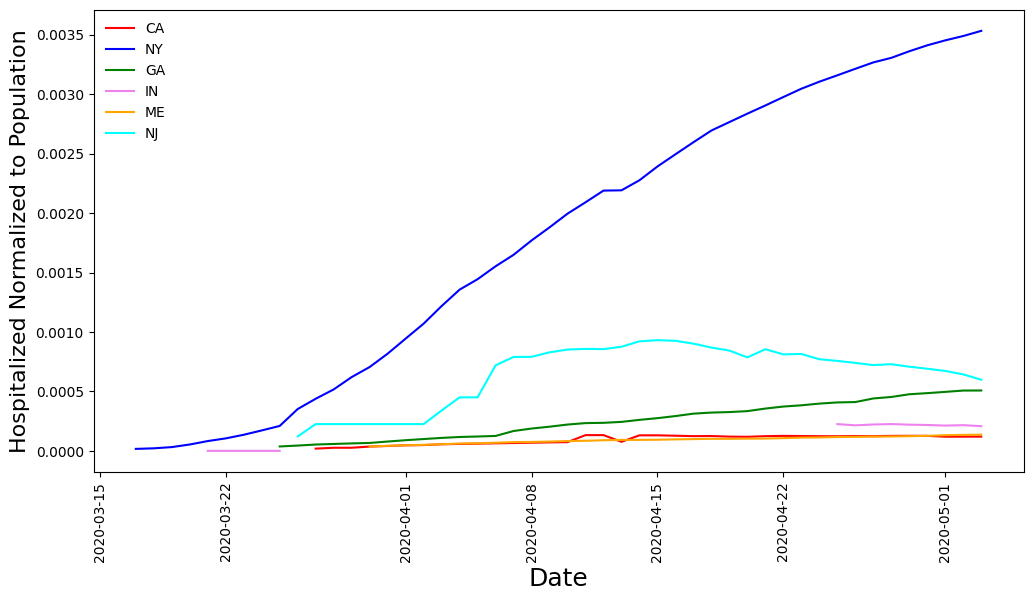

In [28]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].hospitalized_norm, color="red", label="CA")
plt.plot(df_state_dict['NY'].hospitalized_norm, color="blue", label="NY")
plt.plot(df_state_dict['GA'].hospitalized_norm, color="green", label="GA")
plt.plot(df_state_dict['IN'].hospitalized_norm, color="violet", label="IN")
plt.plot(df_state_dict['ME'].hospitalized_norm, color="orange", label="ME")
plt.plot(df_state_dict['NJ'].hospitalized_norm, color="cyan", label="NJ")
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Hospitalized Normalized to Population', fontsize=16)
plt.show()

In several states, population normalized hospitalizations plateau, although population normalized death rate continues to grow.

No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

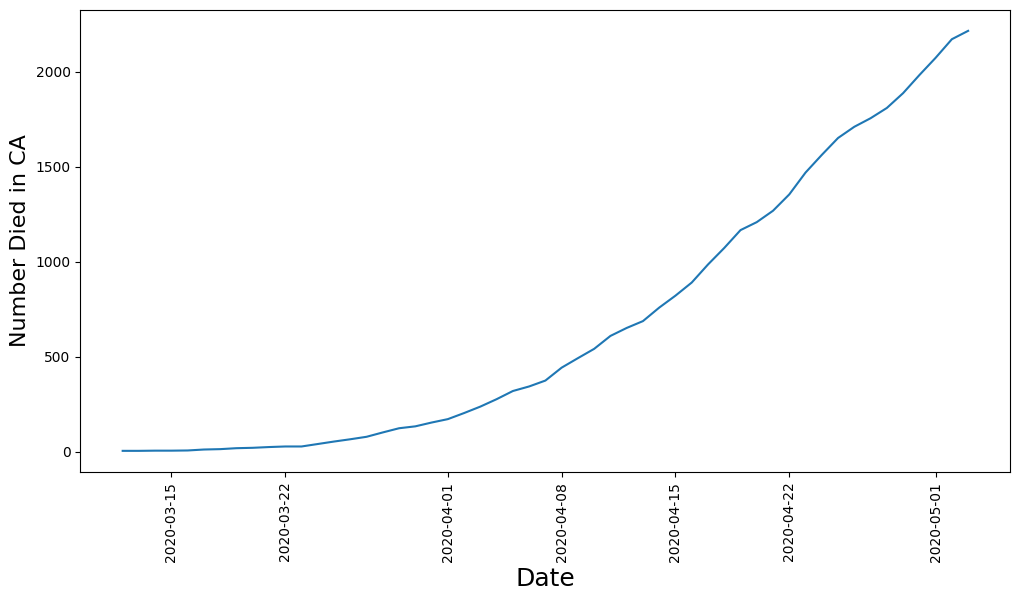

In [29]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].death)
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number Died in CA', fontsize=16)
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

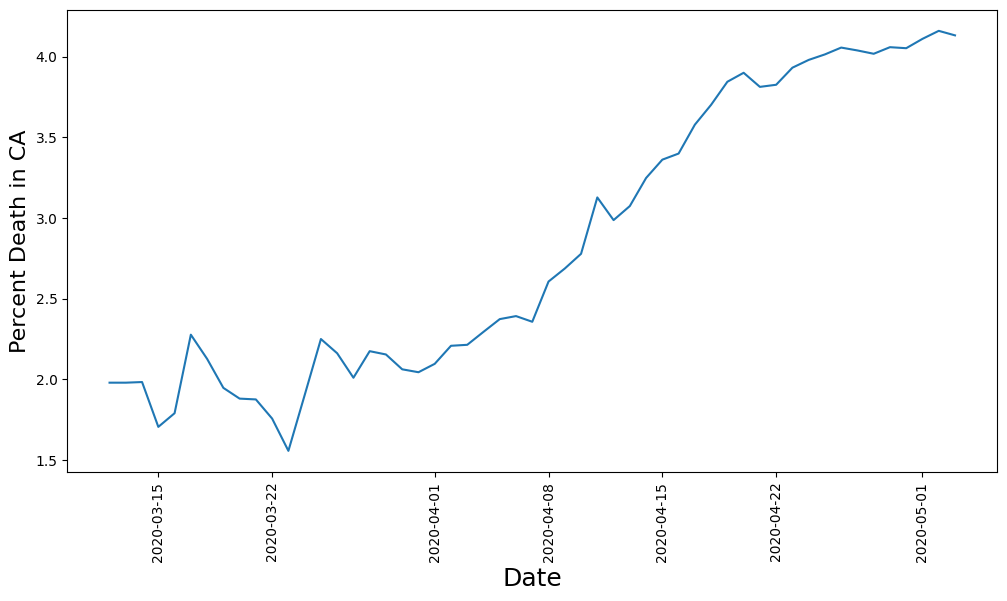

In [30]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].death_percent)
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percent Death in CA', fontsize=16)
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

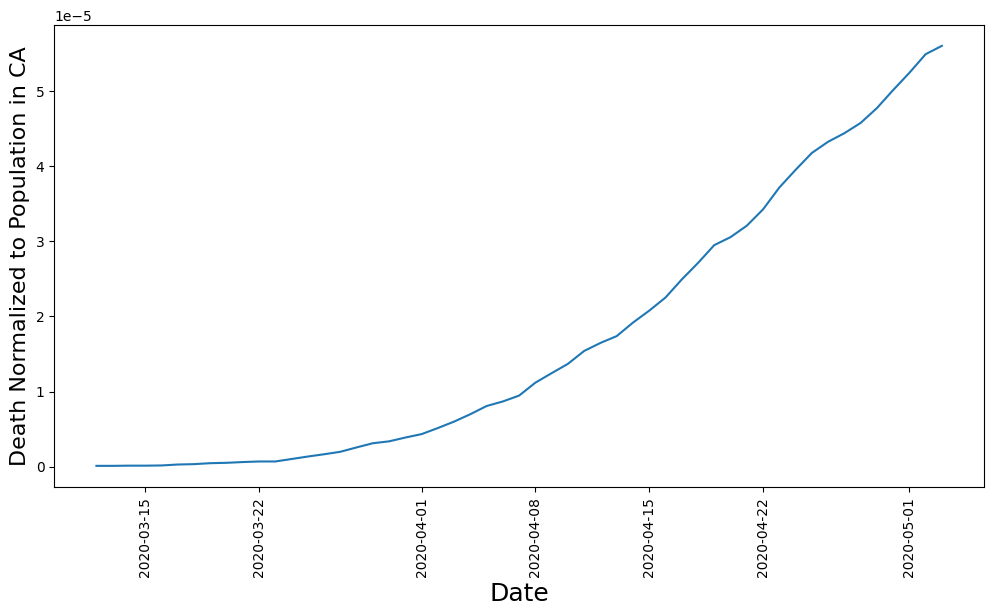

In [31]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].death_norm)
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Death Normalized to Population in CA', fontsize=16)
plt.show()

<Figure size 640x480 with 0 Axes>

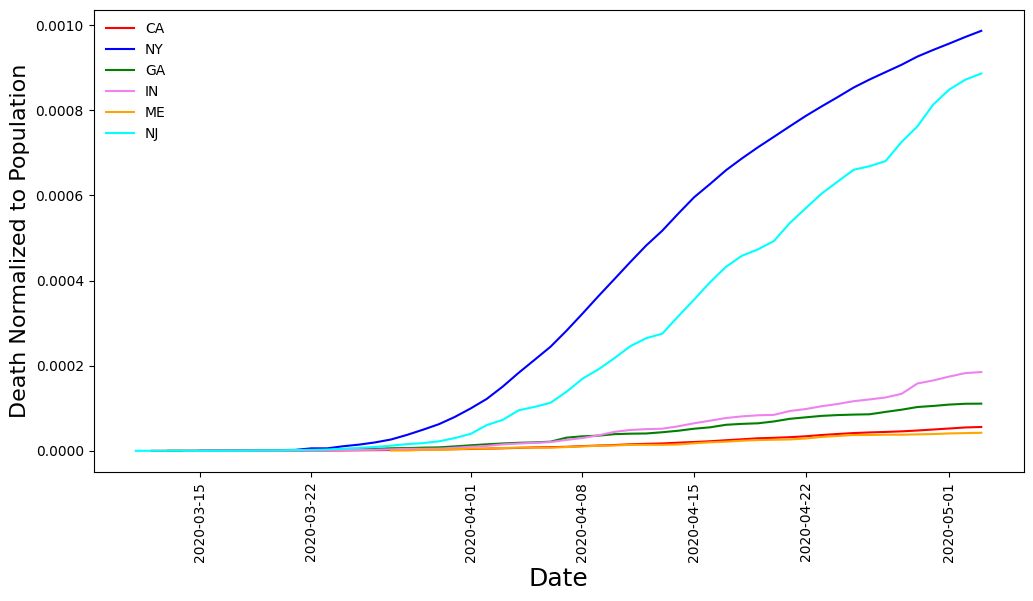

In [32]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(df_state_dict['CA'].death_norm, color="red", label="CA")
plt.plot(df_state_dict['NY'].death_norm, color="blue", label="NY")
plt.plot(df_state_dict['GA'].death_norm, color="green", label="GA")
plt.plot(df_state_dict['IN'].death_norm, color="violet", label="IN")
plt.plot(df_state_dict['ME'].death_norm, color="orange", label="ME")
plt.plot(df_state_dict['NJ'].death_norm, color="cyan", label="NJ")
plt.xticks(rotation='vertical')

plt.legend(frameon=False)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Death Normalized to Population', fontsize=16)
plt.show()

Note how the population normalized death curves relate closely to population normalized postive test curves

In [0]:
# Curve fitting done at:  http://www.xuru.org/rt/NLR.asp#CopyPaste

In [35]:
# Fetch the parameters for each state (AexpBx^-1.csv) that fit to positive_norm = a*exp(b/x)
# where x is the number of days from March 4, 2020
from google.colab import files
uploaded = files.upload()

Saving AexpBx^-1.csv to AexpBx^-1.csv


In [36]:
# Load the parameters for each state (AexpBx^-1.csv) that fit to positive_norm = a*exp(b/x)
import io
df_state_params = pd.read_csv(io.StringIO(uploaded['AexpBx^-1.csv'].decode('utf-8')))
df_state_params.head()

,State,a (10^-3),b,fit rank,r^2
0,AK,2.593040,-75.366476,1.0,0.996906
1,AL,12.121593,-111.222242,2.0,0.997430
2,AR,2.941186,-75.356785,4.0,0.997586
3,AS,NaN,NaN,NaN,NaN
4,AZ,4.984063,-90.295019,1.0,0.998613


In [37]:
df_state_params.describe()

,a (10^-3),b,fit rank,r^2
count,52.000000,52.000000,52.000000,52.000000
mean,16.215254,-100.951881,1.769231,0.995682
std,31.801661,25.545128,1.095720,0.004749
min,1.952592,-185.986576,1.000000,0.972728
25%,5.041013,-116.155268,1.000000,0.995399
50%,7.113788,-99.476492,1.000000,0.997030
75%,10.698133,-80.847333,2.000000,0.998087
max,190.553218,-49.104858,5.000000,0.999660


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f093e578940>]],
      dtype=object)

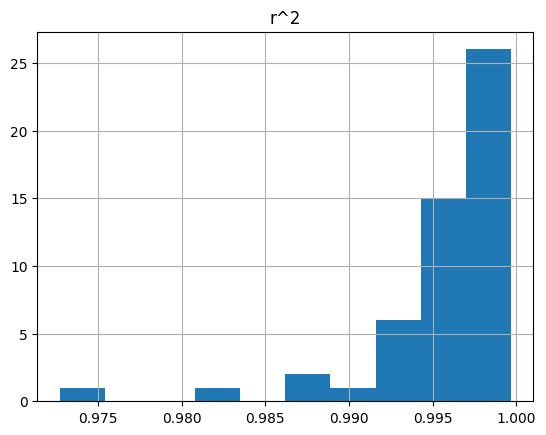

In [38]:
df_state_params.hist(column='r^2')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f093e4ecc18>]],
      dtype=object)

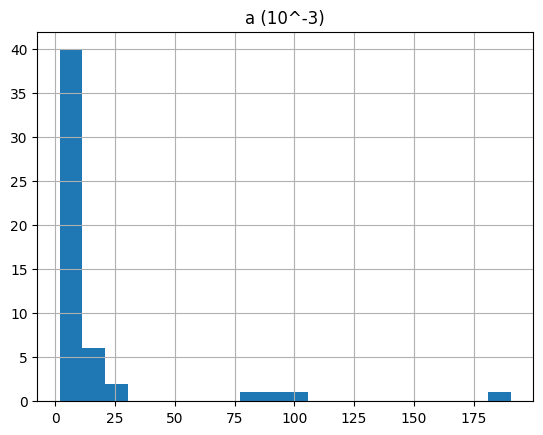

In [39]:
df_state_params.hist(column='a (10^-3)', bins=20)

High value outliers here are NJ (fit rank 1), NY, (fit rank 1), RI (fit rank 5), and SD (fit rank 4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f093e48b780>]],
      dtype=object)

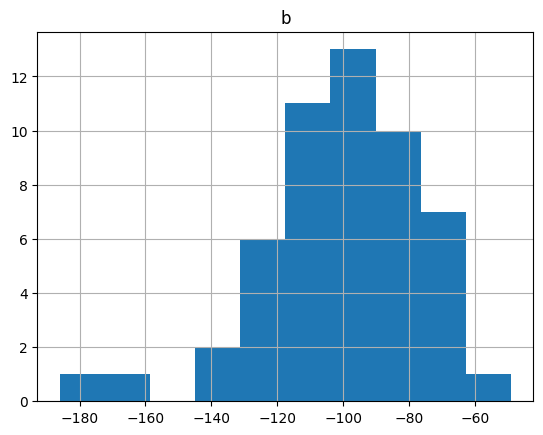

In [40]:
df_state_params.hist(column='b', bins=10)

Low value outliers here are RI (fit rank 5) and SD (fit rank 4).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f093e433ba8>]],
      dtype=object)

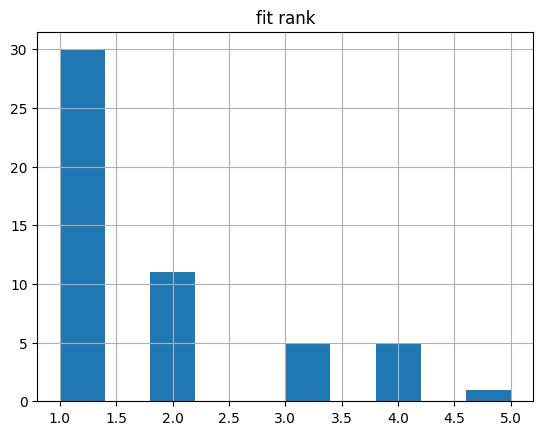

In [41]:
df_state_params.hist(column='fit rank')

The A*exp(B/x) functional form works extremely well for thirty of the 52 states (57.7%).

In [44]:
# Fetch static data for each state (CovidCompleteStateData.csv)
from google.colab import files
uploaded = files.upload()

Saving CovidCompleteStateData.csv to CovidCompleteStateData.csv


In [45]:
# Load static data for each state (CovidCurrentStateData.csv)
import io
df_state_data = pd.read_csv(io.StringIO(uploaded['CovidCompleteStateData.csv'].decode('utf-8')))
df_state_data.head()

,State,Sum of NUM_Medicare_BEN,Sum of NUM_BEN_Age_Less_65,Sum of NUM_BEN_Age_65_to_74,Sum of NUM_BEN_Age_75_to_84,Sum of NUM_BEN_Age_Greater_84,Sum of NUM_Female_BEN,Sum of NUM_Male_BEN,Sum of NUM_Black_or_African_American_BEN,Sum of NUM_Asian_Pacific_Islander_BEN,Sum of NUM_Hispanic_BEN,Sum of NUM_American_IndianAlaska_Native_BEN,Sum of NUM_BEN_With_Race_Not_Elsewhere_Classified,Sum of NUM_Non-Hispanic_White_BEN,Sum of NUM_Minorities,Sum of Average_Age_of_BEN,Sum of NUM_BEN_Atrial_Fibrillation,Sum of NUM_BEN_Asthma,Sum of NUM_BEN_Cancer,Sum of NUM_BEN_Heart_Failure,Sum of NUM_BEN_Chronic_Kidney_Disease,Sum of NUM_BEN_Chronic_Obstructive_Pulmonary_Disease,Sum of NUM_BEN_Hyperlipidemia,Sum of NUM_BEN_Diabetes,Sum of NUM_BEN_Hypertension,Sum of NUM_BEN_Ischemic_Heart_Disease,Sum of NUM_BEN_Stroke,Sum of PCT_MEDICARE,% Urban Pop,Density (P/mi2),Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,65+,Latitude,Longitude,Land Area,Water Area,...,50-69yearsIschemicheartdisease,50-69yearsNeoplasms,50-69yearsOtherchronicrespiratorydiseases,50-69yearsRheumaticheartdisease,50-69yearsStroke,70+yearsAllcauses,70+yearsAsthma,70+yearsChronickidneydisease,70+yearsChronicobstructivepulmonarydisease,70+yearsDiabetesmellitus,70+yearsInterstitiallungdiseaseandpulmonarysarcoidosis,70+yearsIschemicheartdisease,70+yearsNeoplasms,70+yearsOtherchronicrespiratorydiseases,70+yearsRheumaticheartdisease,70+yearsStroke,AllAgesAllcauses,AllAgesAsthma,AllAgesChronickidneydisease,AllAgesChronicobstructivepulmonarydisease,AllAgesDiabetesmellitus,AllAgesInterstitiallungdiseaseandpulmonarysarcoidosis,AllAgesIschemicheartdisease,AllAgesNeoplasms,AllAgesOtherchronicrespiratorydiseases,AllAgesRheumaticheartdisease,AllAgesStroke,AllAgesTotal,Airpollution,Highbody-massindex,Highfastingplasmaglucose,HighLDLcholesterol,Highsystolicbloodpressure,Impairedkidneyfunction,Noaccesstohandwashingfacility,Smoking,Log10Pop,DaysSinceInfection,Children0-18,Allriskfactors
0,AK,1820384.0,270970.0,809516.0,468255.0,175296.0,1034762.0,760009.0,62311.0,76773.0,46525.0,147917.0,23372.0,1207054.0,356898.0,996.298679,1.246184e+05,89514.88771,137399.914,256113.168,4.765594e+05,232171.648,5.553624e+05,4.379772e+05,1.001016e+06,4.094432e+05,44513.06715,10.069041,66.0,1.2863,181405.17,60468.39,87343.23,174686.46,87343.23,80624.52,61.370716,-152.404419,570665.0,94343.0,...,7401.111054,17358.20100,118.764930,227.241828,2756.291431,40420.0516,126.211902,955.444869,3326.558171,1730.343499,294.318687,4488.027423,8223.517066,35.584878,156.854247,2673.487967,222098.060,1486.811652,2828.817996,8034.549041,7436.42900,779.843281,13404.48314,30416.84967,330.899251,501.561597,6390.339899,2.937086e+05,6290.441832,42849.93964,31928.93365,14174.61076,26325.63884,9116.36826,66.983817,39514.96032,5.865697,31.0,0.27,1.954898e+05
1,AL,10804823.0,2065353.0,4386595.0,2980828.0,1190504.0,6237445.0,4514041.0,1549811.0,30624.0,65500.0,5556.0,58660.0,8260982.0,1710151.0,3967.220634,1.187248e+06,800114.46500,1169001.427,2516128.304,4.167531e+06,2066509.729,5.879564e+06,3.802273e+06,7.676071e+06,4.125444e+06,622846.46400,51.254704,59.0,96.9221,1105570.08,414588.78,552785.04,1151635.50,644915.88,783112.14,32.806671,-86.791130,50644.0,1776.0,...,80013.044560,155300.99850,1269.670979,1843.210299,33666.192580,505829.8863,1352.336696,15918.716590,47156.082420,19890.422770,3052.268454,72780.081950,94067.795640,474.187066,1952.986147,39548.027210,1875057.249,10455.994620,39508.118400,101688.766400,72351.04243,6905.402659,174621.81490,286762.75830,3307.422404,4682.703699,84590.651710,2.659932e+06,120555.190900,464371.19430,409403.59280,180755.57560,343659.78330,131418.72910,761.133702,469931.05340,6.690960,30.0,0.24,1.837701e+06
2,AR,15892716.0,2818665.0,6370265.0,4555468.0,1848506.0,9275039.0,6507151.0,1334245.0,19642.0,108428.0,62782.0,61250.0,13052037.0,1586347.0,3928.834167,1.876794e+06,988031.93310,1742834.628,3513573.918,5.247401e+06,2889204.866,7.447698e+06,4.901948e+06,1.087043e+07,6.226359e+06,940064.169

In [0]:
# Feature Engineering
# Land Area/Water Area
# df_state_data['State Area Ratio'] = df_state_data['Land Area']/df_state_data['Water Area']
df_state_data['State Area Ratio'] = df_state_data['Land Area'].divide(df_state_data['Water Area'], fill_value=0)

# Elevation Ratio = Highest Elevation/Mean Elevation
# df_state_data['Elevation Ratio'] = df_state_data['Highest Elevation']/df_state_data['Mean Elevation']
df_state_data['Elevation Ratio'] = df_state_data['Highest Elevation'].divide(df_state_data['Mean Elevation'], fill_value=0)

# Capital Area Ratio = Capital Land Area/Capital Water Area
# df_state_data['Capital Area Ratio'] = df_state_data['Captial Land Area']/df_state_data['Capital Water Area']
df_state_data['Captial Land Area'] = df_state_data['Captial Land Area'].astype(float)
df_state_data['Capital Area Ratio'] = df_state_data['Captial Land Area'].divide(df_state_data['Capital Water Area'], fill_value=0)

# Boundaries = Number of boarding states + On Coast + Borders Another Country
df_state_data['Boundaries'] = df_state_data['Number of bordering states'] + df_state_data['On Coast'] + df_state_data['Borders Another Country']

# Latitude Difference to State Capital = Latitude - Capital Latitude
df_state_data['Latitude Difference to State Capital'] = df_state_data['Latitude'] - df_state_data['Capital Latitude']

# Longitude Difference to State Capital = Capital Longitude - Longitude
df_state_data['Longitude Difference to State Capital'] = df_state_data['Capital Longitude'] - df_state_data['Longitude']

# Latitude Difference to DC = Latitude - DC Latitude
df_state_data['Latitude Difference to DC'] = df_state_data['Latitude'] - 38.904722

# Longitude Difference to DC = DC Longitude - Longitude
df_state_data['Longitude Difference to DC'] = -77.016389 - df_state_data['Longitude']

# Latitude Difference to US Center = Latitude - Center Latitude
df_state_data['Latitude Difference to Center'] = df_state_data['Latitude'] - 39.833333

# Longitude Different to US Center = Center Longitude - Longitude
df_state_data['Longitude Difference to Center'] = -98.585522 - df_state_data['Longitude']

In [47]:
df_state_data.head()

,State,Sum of NUM_Medicare_BEN,Sum of NUM_BEN_Age_Less_65,Sum of NUM_BEN_Age_65_to_74,Sum of NUM_BEN_Age_75_to_84,Sum of NUM_BEN_Age_Greater_84,Sum of NUM_Female_BEN,Sum of NUM_Male_BEN,Sum of NUM_Black_or_African_American_BEN,Sum of NUM_Asian_Pacific_Islander_BEN,Sum of NUM_Hispanic_BEN,Sum of NUM_American_IndianAlaska_Native_BEN,Sum of NUM_BEN_With_Race_Not_Elsewhere_Classified,Sum of NUM_Non-Hispanic_White_BEN,Sum of NUM_Minorities,Sum of Average_Age_of_BEN,Sum of NUM_BEN_Atrial_Fibrillation,Sum of NUM_BEN_Asthma,Sum of NUM_BEN_Cancer,Sum of NUM_BEN_Heart_Failure,Sum of NUM_BEN_Chronic_Kidney_Disease,Sum of NUM_BEN_Chronic_Obstructive_Pulmonary_Disease,Sum of NUM_BEN_Hyperlipidemia,Sum of NUM_BEN_Diabetes,Sum of NUM_BEN_Hypertension,Sum of NUM_BEN_Ischemic_Heart_Disease,Sum of NUM_BEN_Stroke,Sum of PCT_MEDICARE,% Urban Pop,Density (P/mi2),Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,65+,Latitude,Longitude,Land Area,Water Area,...,70+yearsInterstitiallungdiseaseandpulmonarysarcoidosis,70+yearsIschemicheartdisease,70+yearsNeoplasms,70+yearsOtherchronicrespiratorydiseases,70+yearsRheumaticheartdisease,70+yearsStroke,AllAgesAllcauses,AllAgesAsthma,AllAgesChronickidneydisease,AllAgesChronicobstructivepulmonarydisease,AllAgesDiabetesmellitus,AllAgesInterstitiallungdiseaseandpulmonarysarcoidosis,AllAgesIschemicheartdisease,AllAgesNeoplasms,AllAgesOtherchronicrespiratorydiseases,AllAgesRheumaticheartdisease,AllAgesStroke,AllAgesTotal,Airpollution,Highbody-massindex,Highfastingplasmaglucose,HighLDLcholesterol,Highsystolicbloodpressure,Impairedkidneyfunction,Noaccesstohandwashingfacility,Smoking,Log10Pop,DaysSinceInfection,Children0-18,Allriskfactors,State Area Ratio,Elevation Ratio,Capital Area Ratio,Boundaries,Latitude Difference to State Capital,Longitude Difference to State Capital,Latitude Difference to DC,Longitude Difference to DC,Latitude Difference to Center,Longitude Difference to Center
0,AK,1820384.0,270970.0,809516.0,468255.0,175296.0,1034762.0,760009.0,62311.0,76773.0,46525.0,147917.0,23372.0,1207054.0,356898.0,996.298679,1.246184e+05,89514.88771,137399.914,256113.168,4.765594e+05,232171.648,5.553624e+05,4.379772e+05,1.001016e+06,4.094432e+05,44513.06715,10.069041,66.0,1.2863,181405.17,60468.39,87343.23,174686.46,87343.23,80624.52,61.370716,-152.404419,570665.0,94343.0,...,294.318687,4488.027423,8223.517066,35.584878,156.854247,2673.487967,222098.060,1486.811652,2828.817996,8034.549041,7436.42900,779.843281,13404.48314,30416.84967,330.899251,501.561597,6390.339899,2.937086e+05,6290.441832,42849.93964,31928.93365,14174.61076,26325.63884,9116.36826,66.983817,39514.96032,5.865697,31.0,0.27,1.954898e+05,6.048832,10.694737,4.908720,3.0,3.069316,17.982819,22.465994,75.388030,21.537383,53.818897
1,AL,10804823.0,2065353.0,4386595.0,2980828.0,1190504.0,6237445.0,4514041.0,1549811.0,30624.0,65500.0,5556.0,58660.0,8260982.0,1710151.0,3967.220634,1.187248e+06,800114.46500,1169001.427,2516128.304,4.167531e+06,2066509.729,5.879564e+06,3.802273e+06,7.676071e+06,4.125444e+06,622846.46400,51.254704,59.0,96.9221,1105570.08,414588.78,552785.04,1151635.50,644915.88,783112.14,32.806671,-86.791130,50644.0,1776.0,...,3052.268454,72780.081950,94067.795640,474.187066,1952.986147,39548.027210,1875057.249,10455.994620,39508.118400,101688.766400,72351.04243,6905.402659,174621.81490,286762.75830,3307.422404,4682.703699,84590.651710,2.659932e+06,120555.190900,464371.19430,409403.59280,180755.57560,343659.78330,131418.72910,761.133702,469931.05340,6.690960,30.0,0.24,1.837701e+06,28.515766,4.810000,68.307692,7.0,0.444971,0.511930,-6.098051,9.774741,-7.026662,-11.794392
2,AR,15892716.0,2818665.0,6370265.0,4555468.0,1848506.0,9275039.0,6507151.0,1334245.0,19642.0,108428.0,62782.0,61250.0,13052037.0,1586347.0,3928.834167,1.876794e+06,988031.93310,1742834.628,3513573.918,5.247401e+06,2889204.866,7.447698e+06,4.901948e+06,1.087043e+07,6.226359e+06,940064.16960,94.570949,56.2,58.4030,686482.50,247133.70,329511.60,686482.50,356970.90,466

In [48]:
df_state_data.shape

(56, 126)

In [0]:
# Define variables for regression
df_temp1 = df_state_data.drop(df_state_data.index[[3, 12, 27, 42, 50]])
X = df_temp1.drop('State', axis = 1)
df_temp2 = df_state_params.drop(df_state_data.index[[3, 12, 27, 42, 50]])
y = df_temp2['a (10^-3)']

In [50]:
# Look at correlation coefficients
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
X.corr()

,Sum of NUM_Medicare_BEN,Sum of NUM_BEN_Age_Less_65,Sum of NUM_BEN_Age_65_to_74,Sum of NUM_BEN_Age_75_to_84,Sum of NUM_BEN_Age_Greater_84,Sum of NUM_Female_BEN,Sum of NUM_Male_BEN,Sum of NUM_Black_or_African_American_BEN,Sum of NUM_Asian_Pacific_Islander_BEN,Sum of NUM_Hispanic_BEN,Sum of NUM_American_IndianAlaska_Native_BEN,Sum of NUM_BEN_With_Race_Not_Elsewhere_Classified,Sum of NUM_Non-Hispanic_White_BEN,Sum of NUM_Minorities,Sum of Average_Age_of_BEN,Sum of NUM_BEN_Atrial_Fibrillation,Sum of NUM_BEN_Asthma,Sum of NUM_BEN_Cancer,Sum of NUM_BEN_Heart_Failure,Sum of NUM_BEN_Chronic_Kidney_Disease,Sum of NUM_BEN_Chronic_Obstructive_Pulmonary_Disease,Sum of NUM_BEN_Hyperlipidemia,Sum of NUM_BEN_Diabetes,Sum of NUM_BEN_Hypertension,Sum of NUM_BEN_Ischemic_Heart_Disease,Sum of NUM_BEN_Stroke,Sum of PCT_MEDICARE,% Urban Pop,Density (P/mi2),Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,65+,Latitude,Longitude,Land Area,Water Area,Mean Elevation,Highest Elevation,Lowest elevation,Number of bordering states,On Coast,Borders Another Country,Capital Latitude,Capital Longitude,Captial Land Area,Capital Water Area,Capital Mean Elevation,Capital is the Largest City,Largest City Latitude,Largest City Longitude,Number of Counties,Became a State,DaysSinceStayatHomeOrder,DaysSinceFirstPositive,DaysSinceTestStart,15-49yearsAllcauses,15-49yearsAsthma,15-49yearsChronickidneydisease,15-49yearsChronicobstructivepulmonarydisease,15-49yearsDiabetesmellitus,15-49yearsInterstitiallungdiseaseandpulmonarysarcoidosis,15-49yearsIschemicheartdisease,15-49yearsNeoplasms,15-49yearsOtherchronicrespiratorydiseases,15-49yearsRheumaticheartdisease,15-49yearsStroke,50-69yearsAllcauses,50-69yearsAsthma,50-69yearsChronickidneydisease,50-69yearsChronicobstructivepulmonarydisease,50-69yearsDiabetesmellitus,50-69yearsInterstitiallungdiseaseandpulmonarysarcoidosis,50-69yearsIschemicheartdisease,50-69yearsNeoplasms,50-69yearsOtherchronicrespiratorydiseases,50-69yearsRheumaticheartdisease,50-69yearsStroke,70+yearsAllcauses,70+yearsAsthma,70+yearsChronickidneydisease,70+yearsChronicobstructivepulmonarydisease,70+yearsDiabetesmellitus,70+yearsInterstitiallungdiseaseandpulmonarysarcoidosis,70+yearsIschemicheartdisease,70+yearsNeoplasms,70+yearsOtherchronicrespiratorydiseases,70+yearsRheumaticheartdisease,70+yearsStroke,AllAgesAllcauses,AllAgesAsthma,AllAgesChronickidneydisease,AllAgesChronicobstructivepulmonarydisease,AllAgesDiabetesmellitus,AllAgesInterstitiallungdiseaseandpulmonarysarcoidosis,AllAgesIschemicheartdisease,AllAgesNeoplasms,AllAgesOtherchronicrespiratorydiseases,AllAgesRheumaticheartdisease,AllAgesStroke,AllAgesTotal,Airpollution,Highbody-massindex,Highfastingplasmaglucose,HighLDLcholesterol,Highsystolicbloodpressure,Impairedkidneyfunction,Noaccesstohandwashingfacility,Smoking,Log10Pop,DaysSinceInfection,Children0-18,Allriskfactors,State Area Ratio,Elevation Ratio,Capital Area Ratio,Boundaries,Latitude Difference to State Capital,Longitude Difference to State Capital,Latitude Difference to DC,Longitude Difference to DC,Latitude Difference to Center,Longitude Difference to Center
Sum of NUM_Medicare_BEN,1.000000,0.981404,0.998624,0.998100,0.989961,0.999917,0.999897,0.896692,0.525530,0.893302,0.082561,0.823477,0.996838,0.958442,0.682483,0.990425,0.995532,0.994765,0.997133,0.997501,0.986234,0.996237,0.997754,0.998856,0.994006,0.990547,0.713702,0.246412,-0.095479,0.886252,0.865749,0.848661,0.861684,0.840536,0.842520,-0.400391,0.046601,0.229013,0.042895,-0.163276,-0.059881,-0.354394,0.077790,0.471024,0.358143,-0.388663,0.027375,0.008902,-0.087670,-0.194009,-0.171080,-0.421170,0.057094,0.663716,-0.140415,-0.020651,0.368252,0.290649,0.888203,0.824682,0.918864,0.896769,0.912330,0.881251,0.928387,0.887461,0.906636,0.903473,0.919789,0.880146,0.801803,0.917312,0.879259,0.882501,0.863191,0.905979,0.872500,0.885021,0.892519,0.907993,0.849263,0.791486,0.877077,0.866728,0.845276,0.833832,0.841243,0.837485,0.875916,0.844465,0.871562,0.880003,0.833253,0.905

In [0]:
#  Note that there are many highly correlated features which need to be dropped
# Create absolute value correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features by index which were identified as being highly correlated
X = X.drop(X[to_drop], axis=1)

In [52]:
X.head()

,Sum of NUM_Medicare_BEN,Sum of NUM_Black_or_African_American_BEN,Sum of NUM_Asian_Pacific_Islander_BEN,Sum of NUM_Hispanic_BEN,Sum of NUM_American_IndianAlaska_Native_BEN,Sum of NUM_BEN_With_Race_Not_Elsewhere_Classified,Sum of Average_Age_of_BEN,Sum of PCT_MEDICARE,% Urban Pop,Density (P/mi2),Children 0-18,Latitude,Longitude,Land Area,Water Area,Mean Elevation,Highest Elevation,Lowest elevation,Number of bordering states,On Coast,Borders Another Country,Captial Land Area,Capital Water Area,Capital Mean Elevation,Capital is the Largest City,Became a State,DaysSinceStayatHomeOrder,DaysSinceFirstPositive,DaysSinceTestStart,Log10Pop,DaysSinceInfection,Children0-18,State Area Ratio,Elevation Ratio,Capital Area Ratio,Boundaries,Latitude Difference to State Capital,Longitude Difference to State Capital
0,1820384.0,62311.0,76773.0,46525.0,147917.0,23372.0,996.298679,10.069041,66.0,1.2863,181405.17,61.370716,-152.404419,570665.0,94343.0,1900.0,20320.0,0.0,0.0,2.0,1.0,2703.87,550.83,56.0,0.0,1959.0,17.0,32.0,39.0,5.865697,31.0,0.27,6.048832,10.694737,4.908720,3.0,3.069316,17.982819
1,10804823.0,1549811.0,30624.0,65500.0,5556.0,58660.0,3967.220634,51.254704,59.0,96.9221,1105570.08,32.806671,-86.791130,50644.0,1776.0,500.0,2405.0,0.0,4.0,3.0,0.0,159.84,2.34,240.0,0.0,1819.0,9.0,32.0,34.0,6.690960,30.0,0.24,28.515766,4.810000,68.307692,7.0,0.444971,0.511930
2,15892716.0,1334245.0,19642.0,108428.0,62782.0,61250.0,3928.834167,94.570949,56.2,58.4030,686482.50,34.969704,-92.373123,52030.0,1149.0,650.0,2753.0,55.0,6.0,0.0,0.0,119.22,2.80,335.0,1.0,1836.0,0.0,33.0,39.0,6.482731,31.0,0.25,45.282855,4.235385,42.578571,6.0,0.233604,0.042023
4,10786064.0,221183.0,61840.0,689880.0,179818.0,114903.0,1009.367955,14.075942,89.8,64.9550,1744612.56,33.729759,-111.431221,113595.0,396.0,4100.0,12633.0,70.0,5.0,0.0,2.0,517.67,1.25,1086.0,0.0,1912.0,14.0,41.0,41.0,6.867968,33.0,0.24,286.856061,3.081220,414.136000,7.0,0.279759,-0.635479
5,42579588.0,2072012.0,3276415.0,5674776.0,113871.0,562214.0,4001.853612,63.398334,95.0,256.3727,9481941.36,36.116203,-119.681564,155766.0,7928.0,2900.0,14494.0,-2822.0,3.0,2.0,2.0,97.92,2.18,30.0,0.0,1850.0,25.0,41.0,41.0,7.601381,33.0,0.24,19.647578,4.997931,44.917431,7.0,-2.439397,-1.787336


In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 55
Data columns (total 38 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Sum of NUM_Medicare_BEN                            51 non-null     float64
 1   Sum of NUM_Black_or_African_American_BEN           51 non-null     float64
 2   Sum of NUM_Asian_Pacific_Islander_BEN              51 non-null     float64
 3   Sum of NUM_Hispanic_BEN                            51 non-null     float64
 4   Sum of NUM_American_IndianAlaska_Native_BEN        51 non-null     float64
 5   Sum of NUM_BEN_With_Race_Not_Elsewhere_Classified  51 non-null     float64
 6   Sum of Average_Age_of_BEN                          51 non-null     float64
 7   Sum of PCT_MEDICARE                                51 non-null     float64
 8   % Urban Pop                                        51 non-null     float64
 9   Density (P/m

In [54]:
X.describe()

,Sum of NUM_Medicare_BEN,Sum of NUM_Black_or_African_American_BEN,Sum of NUM_Asian_Pacific_Islander_BEN,Sum of NUM_Hispanic_BEN,Sum of NUM_American_IndianAlaska_Native_BEN,Sum of NUM_BEN_With_Race_Not_Elsewhere_Classified,Sum of Average_Age_of_BEN,Sum of PCT_MEDICARE,% Urban Pop,Density (P/mi2),Children 0-18,Latitude,Longitude,Land Area,Water Area,Mean Elevation,Highest Elevation,Lowest elevation,Number of bordering states,On Coast,Borders Another Country,Captial Land Area,Capital Water Area,Capital Mean Elevation,Capital is the Largest City,Became a State,DaysSinceStayatHomeOrder,DaysSinceFirstPositive,DaysSinceTestStart,Log10Pop,DaysSinceInfection,Children0-18,State Area Ratio,Elevation Ratio,Capital Area Ratio,Boundaries,Latitude Difference to State Capital,Longitude Difference to State Capital
count,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1.038431e+07,9.464777e+05,1.411691e+05,5.310095e+05,38355.372549,86379.019608,3535.191553,52.223011,74.107843,431.560508,1.486858e+06,39.464823,-93.339380,69251.411765,5179.450980,1747.843137,6049.313725,378.647059,4.352941,1.431373,0.411765,156.582549,15.072824,1096.176471,0.333333,1838.725490,16.137255,37.215686,38.901961,6.592474,31.450980,0.236471,55.429144,4.453527,90.951338,6.196078,0.062681,0.199922
std,1.311026e+07,1.274593e+06,4.722330e+05,1.629961e+06,87337.002647,114765.665446,2518.178494,46.520870,14.885481,1647.225920,1.764935e+06,6.069546,19.288253,85528.386317,14080.146458,1820.957236,5098.740038,918.109510,1.809127,1.652330,0.638012,386.627154,76.869760,1665.255100,0.476095,47.877376,6.434344,3.384161,2.459715,0.454077,1.188507,0.022434,79.647878,2.559425,197.859850,2.297996,0.841667,2.709061
min,1.655870e+05,2.960000e+02,1.660000e+02,4.130000e+02,0.000000,1693.000000,70.002893,0.972106,38.700000,1.286300,1.160123e+05,21.094318,-157.498337,61.000000,7.000000,60.000000,345.000000,-2822.000000,0.000000,0.000000,0.000000,7.210000,0.010000,19.000000,0.000000,1787.000000,0.000000,27.000000,28.000000,5.753602,30.000000,0.190000,1.406694,1.518182,1.174958,2.000000,-2.688721,-2.698515
25%,2.252305e+06,5.366600e+04,6.445500e+03,3.101950e+04,2980.500000,17674.500000,1542.140834,13.385073,65.400000,50.604850,3.984744e+05,35.688955,-102.547558,33332.000000,648.500000,600.000000,1965.000000,0.000000,3.000000,0.000000,0.000000,29.675000,0.780000,147.500000,0.000000,1790.000000,13.000000,34.000000,38.000000,6.255743,30.000000,0.225000,6.836733,2.216352,16.488372,5.000000,-0.209903,-0.620781
50%,6.272609e+06,3.156040e+05,2.579200e+04,1.042170e+05,7061.000000,58660.000000,3578.360041,51.254704,74.200000,108.049700,1.013513e+06,39.849426,-89.616508,53603.000000,1498.000000,1000.000000,4393.000000,55.000000,4.000000,1.000000,0.000000,60.500000,2.000000,525.000000,0.000000,1836.000000,17.000000,38.000000,39.000000,6.653183,31.000000,0.240000,28.515766,3.764412,39.237443,6.000000,0.090846,-0.017259
75%,1.471830e+07,1.547566e+06,7.063400e+04,2.005865e+05,28506.500000,100449.000000,5214.099778,78.017975,87.550000,223.983100,1.719581e+06,43.041292,-78.988193,80684.500000,4233.000000,2100.000000,9994.000000,526.000000,6.000000,2.500000,1.000000,125.710000,3.975000,950.000000,1.000000,1871.500000,21.000000,40.500000,41.000000,6.879950,33.000000,0.250000,59.200401,5.774596,70.722157,7.000000,0.413094,0.317600
max,7.644909e+07,7.011107e+06,3.276415e+06,1.007620e+07,560433.000000,562214.000000,13644.965980,219.756971,100.000000,11814.541000,9.481941e+06,61.370716,-69.381927,570665.000000,94343.000000,6800.000000,20320.000000,3350.000000,8.000000,6.000000,2.000000,2703.870000,550.830000,7199.000000,1.000000,1959.000000,25.000000,41.000000,42.000000,

In [55]:
# Train/validate split: random 75/25% train/validate split.
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((38, 38), (38,), (13, 38), (13,))

In [56]:
X_train.describe()

,Sum of NUM_Medicare_BEN,Sum of NUM_Black_or_African_American_BEN,Sum of NUM_Asian_Pacific_Islander_BEN,Sum of NUM_Hispanic_BEN,Sum of NUM_American_IndianAlaska_Native_BEN,Sum of NUM_BEN_With_Race_Not_Elsewhere_Classified,Sum of Average_Age_of_BEN,Sum of PCT_MEDICARE,% Urban Pop,Density (P/mi2),Children 0-18,Latitude,Longitude,Land Area,Water Area,Mean Elevation,Highest Elevation,Lowest elevation,Number of bordering states,On Coast,Borders Another Country,Captial Land Area,Capital Water Area,Capital Mean Elevation,Capital is the Largest City,Became a State,DaysSinceStayatHomeOrder,DaysSinceFirstPositive,DaysSinceTestStart,Log10Pop,DaysSinceInfection,Children0-18,State Area Ratio,Elevation Ratio,Capital Area Ratio,Boundaries,Latitude Difference to State Capital,Longitude Difference to State Capital
count,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,3.800000e+01,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,1.014125e+07,9.685705e+05,1.623107e+05,3.942231e+05,37676.868421,93816.710526,3549.919212,51.835362,75.578947,509.044824,1.536694e+06,39.769502,-94.847769,71247.763158,6526.263158,1732.368421,6115.157895,378.605263,4.263158,1.736842,0.315789,174.806316,19.654053,1053.289474,0.342105,1840.868421,16.052632,37.447368,39.000000,6.618535,31.421053,0.237632,41.024265,4.369400,87.937711,6.315789,0.060427,0.363112
std,9.963253e+06,1.001560e+06,5.333709e+05,1.021129e+06,93507.556838,120712.415819,2056.853166,40.781616,14.338667,1899.378670,1.707713e+06,6.596259,20.534465,90591.053331,16106.437222,1827.079244,5336.811744,972.727776,1.826002,1.750432,0.525319,440.077506,88.878229,1594.286215,0.480783,47.962920,6.392341,3.090503,2.079501,0.457512,1.222129,0.022110,53.330155,2.587005,216.845725,2.450651,0.945213,3.118105
min,3.472690e+05,2.689000e+03,4.580000e+02,2.622000e+03,45.000000,4201.000000,70.002893,0.972106,38.700000,1.286300,1.365427e+05,21.094318,-157.498337,61.000000,7.000000,100.000000,345.000000,-2822.000000,0.000000,0.000000,0.000000,7.210000,0.010000,19.000000,0.000000,1787.000000,0.000000,32.000000,34.000000,5.753602,30.000000,0.190000,1.406694,1.795714,1.174958,2.000000,-2.688721,-2.698515
25%,2.518838e+06,4.934350e+04,1.427175e+04,3.676725e+04,4699.500000,19802.500000,1590.459797,18.987497,66.125000,43.927350,5.296779e+05,35.839934,-103.929331,40952.250000,969.750000,600.000000,2059.500000,0.000000,3.000000,0.000000,0.000000,32.930000,1.007500,141.000000,0.000000,1791.500000,12.250000,34.500000,38.000000,6.333942,30.000000,0.230000,6.454810,2.141597,9.973945,5.000000,-0.320530,-0.649418
50%,7.473651e+06,5.120990e+05,3.068000e+04,1.071920e+05,9615.500000,62351.000000,3948.027401,53.017662,74.850000,112.688450,1.123149e+06,40.249745,-89.647602,53878.500000,2159.000000,975.000000,4411.500000,0.500000,4.000000,1.000000,0.000000,60.775000,2.195000,327.500000,0.000000,1836.500000,17.000000,38.000000,39.500000,6.678981,31.500000,0.240000,21.399686,3.607206,37.725758,6.000000,0.086983,0.026220
75%,1.563758e+07,1.560497e+06,9.455175e+04,1.983508e+05,27502.250000,100987.500000,5194.290279,79.721735,87.975000,249.285600,1.728603e+06,43.183955,-80.276510,78911.500000,4772.500000,2150.000000,10239.750000,577.250000,6.000000,3.000000,1.000000,129.705000,6.195000,934.250000,1.000000,1873.750000,21.000000,40.750000,40.750000,6.924848,32.750000,0.250000,45.305604,5.348500,69.610158,7.000000,0.433422,0.500574
max,4.257959e+07,3.265865e+06,3.276415e+06,5.674776e+06,560433.000000,562214.000000,7981.626181,185.232318,100.000000,11814.541000,9.481941e+06,61.370716,-69.381927,570665.000000,94343.000000,6800.000000,20320.000000,3350.000000,8.000000,6.000000,2.000000,2703.870000,550.830000,6062.000000,1.000000,1959.000000,25.000000,41.000000,42.000000,7.

In [57]:
# Optimizing Hyperparameters for Random Forest Regressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define classifier
forest = RandomForestRegressor(random_state = 1)

# Parameters to fit

max_depth = [2, 3, 4]
n_estimators = [35, 36, 37]
min_samples_split = [1.5, 2, 2.5]
min_samples_leaf = [3.5, 4, 4.5]
max_leaf_nodes = [None]
max_features = ['auto']
ccp_alpha = [0.0, 0.00625, 0.0125]
min_weight_fraction_leaf = [0.0, 0.00625, 0.0125]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,
              max_leaf_nodes = max_leaf_nodes,
              max_features = max_features,
              ccp_alpha=ccp_alpha,
              min_weight_fraction_leaf=min_weight_fraction_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 10,
                     scoring='r2', return_train_score=True,
                     n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

# Output best accuracy and best parameters
print('The score achieved with the best parameters = ', gridF.best_score_, '\n')
print('The parameters are:', gridF.best_params_)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1862s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1010s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1858s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:  

The score achieved with the best parameters =  -7.248154911069659 

The parameters are: {'ccp_alpha': 0.0, 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 36}


[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed:   43.3s finished


In [58]:
!pip install category_encoders==2.0.0

     |████████████████████████████████| 92kB 2.4MB/s 


In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer

pipeline1 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=36, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False))

pipeline1.fit(X_train, y_train)

# Get the model's training accuracy
print("Training Accurary:  R^2 = ", pipeline1.score(X_train,y_train))

# Get the model's validation accuracy
print('Validation Accuracy:  R^2 = ', pipeline1.score(X_val, y_val))

Training Accurary:  R^2 =  0.3013954634238487
Validation Accuracy:  R^2 =  0.069388620867604


In [60]:
print("Feature Importances =") 
#print(RandomForestRegressor.feature_importances_)
print(pipeline1.steps[2][1].feature_importances_)

Feature Importances =
[1.58960229e-03 5.30566745e-02 4.17410911e-03 1.59284318e-01
 2.61004152e-02 2.17672192e-02 7.81822081e-03 2.43729475e-02
 2.90624300e-03 2.56504641e-02 4.95719120e-02 2.69244094e-02
 1.12768719e-01 1.23221013e-04 4.58989637e-04 2.49941071e-03
 8.43190668e-03 0.00000000e+00 2.63169045e-02 2.37762734e-02
 0.00000000e+00 2.13022103e-01 1.01510181e-01 1.46479728e-04
 0.00000000e+00 2.38233658e-02 5.38444596e-03 0.00000000e+00
 2.61738842e-04 2.59337047e-02 0.00000000e+00 0.00000000e+00
 2.95326741e-03 0.00000000e+00 3.98608558e-03 3.56252545e-02
 3.63475050e-03 6.12666322e-03]


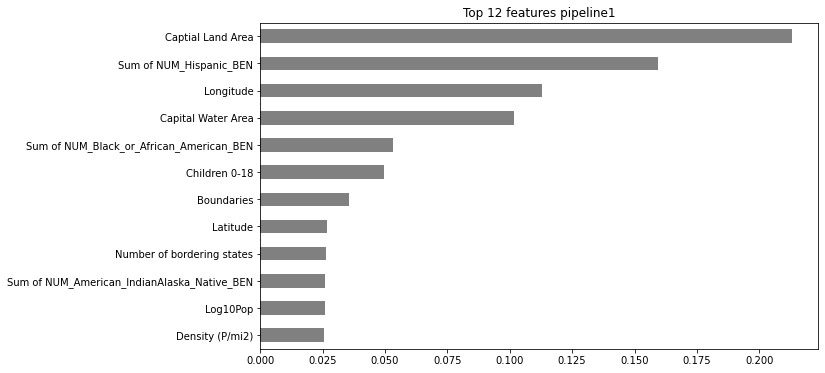

In [61]:
# Plot of feature importances from pure Random Forest Regressor
%matplotlib inline
import matplotlib.pyplot as plt
# Get feature importances
encoder = pipeline1.named_steps['onehotencoder']
encoded = encoder.transform(X_train)
rf = pipeline1.named_steps['randomforestregressor']
importances1 = pd.Series(rf.feature_importances_, encoded.columns)
# Plot feature importances
n = 12
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features pipeline1')
importances1.sort_values()[-n:].plot.barh(color='grey');

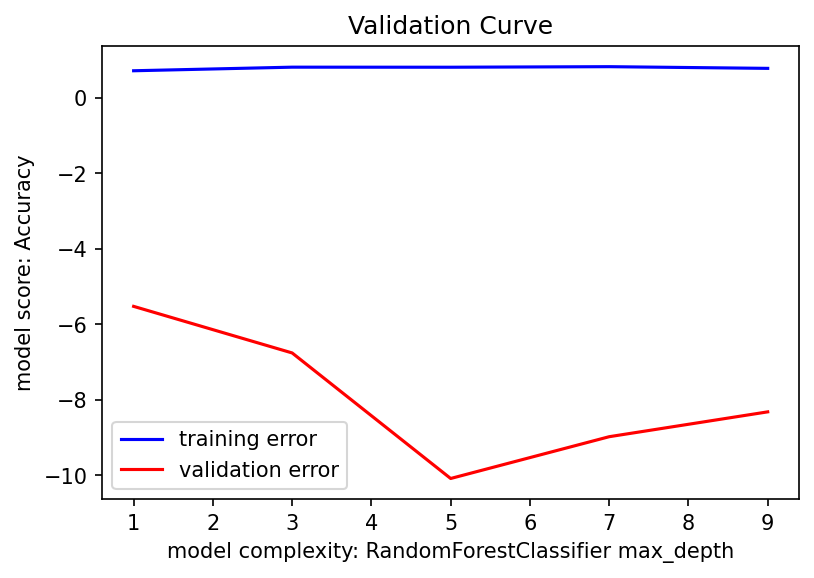

In [62]:
# Generate validation curves
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor()
)

depth = range(1, 10, 2)
train_scores, val_scores = validation_curve(
    pipeline2, X_train, y_train,
    param_name='randomforestregressor__max_depth',
    param_range=depth,
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestClassifier max_depth')
plt.ylabel('model score: Accuracy')
plt.legend();

In [63]:
# Get drop-column importances
column = 'Captial Land Area'

pipeline3 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy = 'most_frequent'),
    RandomForestRegressor(bootstrap=True, ccp_alpha=0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0,
                      n_estimators=36, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False))

# Fit without column
pipeline3.fit(X_train.drop(columns=column), y_train)
score_without = pipeline3.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline3.fit(X_train, y_train)
score_with = pipeline3.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without Captial Land Area: 0.10771758680677601
Validation Accuracy with Captial Land Area: 0.069388620867604
Drop-Column Importance for Captial Land Area: -0.03832896593917201


In [64]:
# Using Eli5 library which does not work with pipelines
transformers = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model1 =     RandomForestRegressor(bootstrap=True, ccp_alpha=0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0,
                      n_estimators=36, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

model1.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0,
                      n_estimators=36, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [65]:
# Get permutation importances
! pip install eli5
from eli5.sklearn import PermutationImportance
import eli5

permuter = PermutationImportance(
    model1,
    scoring='r2',
    n_iter=2,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

     |████████████████████████████████| 112kB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Weight,Feature
0.1883 ± 0.0854,Captial Land Area
0.0239 ± 0.2251,Longitude
0.0091 ± 0.0014,Density (P/mi2)
0.0063 ± 0.0098,Sum of NUM_Black_or_African_American_BEN
0.0049 ± 0.0032,Sum of NUM_Asian_Pacific_Islander_BEN
0.0045 ± 0.0043,Latitude
0.0044 ± 0.0104,Became a State
0.0024 ± 0.0001,Capital Area Ratio
0.0022 ± 0.0019,Sum of Average_Age_of_BEN
0.0021 ± 0.0014,Boundaries


In [66]:
from sklearn.metrics import mean_squared_error, r2_score

# Coefficient of determination r2 for the training set
pipeline_score = permuter.score(X_train_transformed,y_train)
print("Coefficient of determination r2 for the training set.: ", pipeline_score)

# Coefficient of determination r2 for the validation set
pipeline_score = permuter.score(X_val_transformed,y_val)
print("Coefficient of determination r2 for the validation set.: ", pipeline_score)

# The mean squared error
y_pred = permuter.predict(X_val_transformed)
print("Mean squared error: %.2f"% mean_squared_error(y_val, y_pred))

Coefficient of determination r2 for the training set.:  0.3013954634238487
Coefficient of determination r2 for the validation set.:  0.069388620867604
Mean squared error: 530.47


In [67]:
# Captial Land Area continues to be of importance
# Use importances for feature selection
print('Shape before removing features:', X_train.shape)

Shape before removing features: (38, 38)


In [68]:
# Remove features of 0 importance
zero_importance = 0.0
mask = permuter.feature_importances_ > zero_importance
features1 = X_train.columns[mask]
X_train = X_train[features1]
print('Shape after removing features:', X_train.shape)

Shape after removing features: (38, 14)


In [0]:
# Random forest classifier with fourteen features
X_val = X_val[features1]
pipeline4 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy = 'most_frequent'),
    RandomForestRegressor(bootstrap=True, ccp_alpha=0, 
                          max_depth=3, max_features='auto', max_leaf_nodes=None,
                          max_samples=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=4,
                          min_samples_split=2, min_weight_fraction_leaf=0,
                          n_estimators=36, n_jobs=None, oob_score=False,
                          random_state=0, verbose=0, warm_start=False)
)

# Fit on train, score on val
pipeline4.fit(X_train, y_train);

In [70]:
from sklearn.metrics import mean_squared_error, r2_score

# Coefficient of determination r2 for the training set
pipeline_score = pipeline4.score(X_train,y_train)
print("Coefficient of determination r2 for the training set.: ", pipeline_score)

# Coefficient of determination r2 for the validation set
pipeline_score = pipeline4.score(X_val,y_val)
print("Coefficient of determination r2 for the validation set.: ", pipeline_score)

# The mean squared error
y_pred = pipeline4.predict(X_val)
print("Mean squared error: %.2f"% mean_squared_error(y_val, y_pred))

Coefficient of determination r2 for the training set.:  0.26984125703310236
Coefficient of determination r2 for the validation set.:  0.11859396791756194
Mean squared error: 502.42


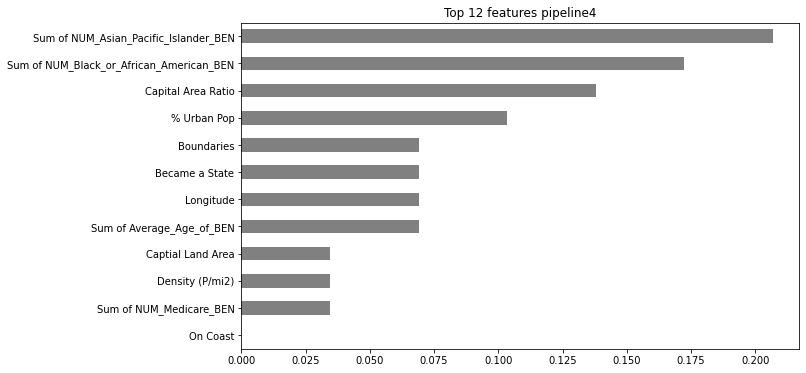

In [71]:
pipeline4.fit(X_val, y_val)
# Plot of features
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
encoder = pipeline4.named_steps['onehotencoder']
encoded = encoder.transform(X_val)
rf = pipeline4.named_steps['randomforestregressor']
importances2 = pd.Series(rf.feature_importances_, encoded.columns)

# Plot feature importances
#n = 4
n = 12
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features pipeline4')
importances2.sort_values()[-n:].plot.barh(color='grey');

In [72]:
!pip install pdpbox

     |████████████████████████████████| 57.7MB 66kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=2eb21b6a2e7bf0b40a562bf76671ac3e8c2da289d9100574197f84c6005f80ca
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [73]:
model2 =     RandomForestRegressor(bootstrap=True, ccp_alpha=0, 
                          max_depth=3, max_features='auto', max_leaf_nodes=None,
                          max_samples=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=4,
                          min_samples_split=2, min_weight_fraction_leaf=0,
                          n_estimators=36, n_jobs=None, oob_score=False,
                          random_state=0, verbose=0, warm_start=False)

model2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0,
                      n_estimators=36, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


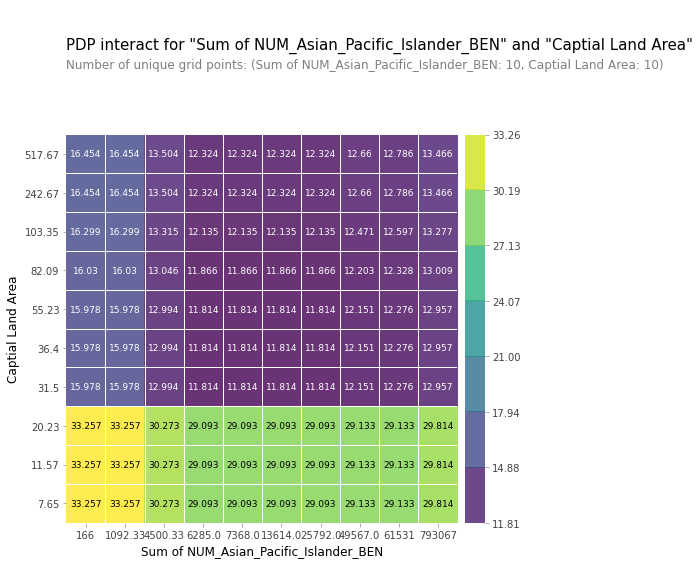

In [74]:
# Partial Dependence Plots with 2 features
from pdpbox.pdp import pdp_interact, pdp_interact_plot
#features2 = ['Density (P/mi2)', 'Captial Land Area']
features2 = ['Sum of NUM_Asian_Pacific_Islander_BEN', 'Captial Land Area']
interaction = pdp_interact(
#                           model=gb,
                           model=model2,
                           dataset=X_val,
                           model_features=X_val.columns,
                           features=features2
                           )
pdp_interact_plot(interaction, plot_type='grid', feature_names=features2);

In [75]:
# A two feature partical dependence plot in 3D
pdp = interaction.pdp.pivot_table(
                                  values='preds',
                                  columns=features2[0],
                                  index=features2[1]
                                  )[::-1] # Slice notation to reverse index order so y axis is ascending
import plotly.graph_objs as go

target = 'Value of a parameter'

surface = go.Surface(x=pdp.columns,
                     y=pdp.index,
                     z=pdp.values)

layout = go.Layout(
                   scene=dict(
                              xaxis=dict(title=features2[0]),
                              yaxis=dict(title=features2[1]),
                              zaxis=dict(title=target)
                              )
)

fig = go.Figure(surface, layout)
fig.show()

In [76]:
! pip install shap==0.23.0
! pip install -I shap

     |████████████████████████████████| 184kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.23.0-cp36-cp36m-linux_x86_64.whl size=235674 sha256=888804ee0ed4369d5a0f68454e9a2429aa16412ebe882b0ab7b63e95ad9b3d4a
  Stored in directory: /root/.cache/pip/wheels/c1/2c/aa/10d1782fe066536fcd564a2f8adea4dd05f57768236038855b
Successfully built shap
     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 20.2MB 1.2MB/s 
     |████████████████████████████████| 26.1MB 1.4MB/s 
     |████████████████████████████████| 7.1MB 41.3MB/s 
     |████████████████████████████████| 10.0MB 174kB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 296kB 51.1MB/s 
     |████████████████████████████████| 235kB 41.7MB/s 
     |████████████████████████████████| 512kB 50.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394123 sha256=5ad6ad0eec64fad88c98344a30ed50224018eb684f8d7c8e546b42ed8dc4

In [77]:
# Local Interpretation using SHAP (for prediction at State # = 4, row 32)
import shap
shap.initjs()
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X_train)
i = 32
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.loc[i], feature_names=X_train.columns)

In [0]:
# Find Shapley Forces across the training sample i (i = 0 - 37)
processor = make_pipeline(
                          ce.OrdinalEncoder(),
                          SimpleImputer(strategy='median')
                          )

X_train_processed = processor.fit_transform(X_train)
column_names = X_train.columns
shap_values_array = pd.DataFrame(columns = column_names)

for i in range(len(y_train)):
        row = X_train.iloc[[i]]
        explainer = shap.TreeExplainer(model2)
        row_processed = processor.transform(row)
        shap_values_input = explainer.shap_values(row_processed)
        shap_values_array = np.concatenate((shap_values_array, shap_values_input), axis=0)

In [79]:
# Create a 3D plot of force as a function of state curve displacement from mean curve and features for validation sample 8
# A two feature partical dependence plot in 3D
import plotly.graph_objs as go
surface = go.Surface(x=column_names,
                     y=y_train,
                     z=shap_values_array)

layout = go.Layout(
        scene=dict(
                 xaxis=dict(title= ''),
                 yaxis=dict(title= 'Value of a for state'),
                 zaxis=dict(title= 'Shapley Force')
)
)
fig = go.Figure(surface, layout)
fig.show()

In [80]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE, f_regression
from sklearn.model_selection import StratifiedKFold

rfr =     RandomForestRegressor(bootstrap=True, ccp_alpha=0, 
                          max_depth=3, max_features='auto', max_leaf_nodes=None,
                          max_samples=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=4,
                          min_samples_split=2, min_weight_fraction_leaf=0,
                          n_estimators=36, n_jobs=None, oob_score=False,
                          random_state=0, verbose=0, warm_start=False)

#Selecting 7 features turns out to give maximum validation accuracy
number_selected_features = 7
rfe = RFE(rfr, n_features_to_select=number_selected_features, verbose =3)
rfe.fit(X_train,y_train)

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0,
                                    criterion='mse', max_depth=3,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=4,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0, n_estimators=36,
                                    n_jobs=None, oob_score=False,
                                    random_state=0, verbose=0,
                                    warm_start=False),
    n_features_to_select=7, step=1, verbose=3)

In [81]:
rfe_support = rfe.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

7 selected features


In [82]:
from sklearn.metrics import mean_squared_error, r2_score

# Coefficient of determination r2 for the training set
pipeline_score = rfe.score(X_train,y_train)
print("Coefficient of determination r2 for the training set.: ", pipeline_score)

# Coefficient of determination r2 for the validation set
pipeline_score = rfe.score(X_val,y_val)
print("Coefficient of determination r2 for the validation set.: ", pipeline_score)

# The mean squared error
y_pred = rfe.predict(X_val)
print("Mean squared error: %.2f"% mean_squared_error(y_val, y_pred))

Coefficient of determination r2 for the training set.:  0.27619181813440996
Coefficient of determination r2 for the validation set.:  0.14111881952867034
Mean squared error: 489.58


In [83]:
# Retain only features with highest importance from RFE
X_train_rfe_select = X_train[rfe_feature]
X_val_rfe_select = X_val[rfe_feature]
print('Shape after removing features:', X_train_rfe_select.shape, X_val_rfe_select.shape)

Shape after removing features: (38, 7) (13, 7)


In [0]:
# Random forest classifier after RFE Feature Selection on Reduced Feature Set

pipeline5 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy = 'most_frequent'),
    RandomForestRegressor(bootstrap=True, ccp_alpha=0, 
                          max_depth=3, max_features='auto', max_leaf_nodes=None,
                          max_samples=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=4,
                          min_samples_split=2, min_weight_fraction_leaf=0,
                          n_estimators=36, n_jobs=None, oob_score=False,
                          random_state=0, verbose=0, warm_start=False)
)

# Fit on train, score on val
pipeline5.fit(X_train_rfe_select, y_train);

In [85]:
# Coefficient of determination r2 for the training set
pipeline_score = pipeline5.score(X_train_rfe_select,y_train)
print("Coefficient of determination r2 for the training set.: ", pipeline_score)

# Coefficient of determination r2 for the validation set
pipeline_score = pipeline5.score(X_val_rfe_select,y_val)
print("Coefficient of determination r2 for the validation set.: ", pipeline_score)

# The mean squared error
y_pred = pipeline5.predict(X_val_rfe_select)
print("Mean squared error: %.2f"% mean_squared_error(y_val, y_pred))

Coefficient of determination r2 for the training set.:  0.27619181813440996
Coefficient of determination r2 for the validation set.:  0.14111881952867034
Mean squared error: 489.58


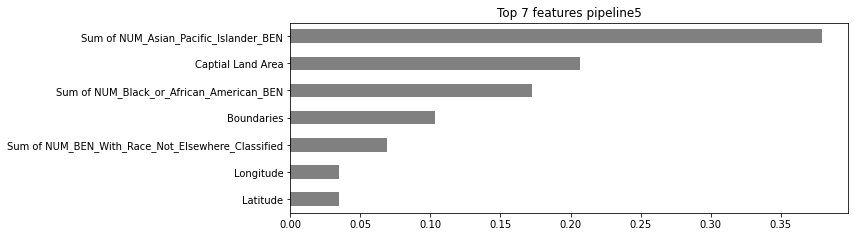

In [86]:
pipeline5.fit(X_val_rfe_select, y_val)
# Plot of features
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
encoder = pipeline5.named_steps['onehotencoder']
encoded = encoder.transform(X_val_rfe_select)
rf = pipeline5.named_steps['randomforestregressor']
importances3 = pd.Series(rf.feature_importances_, encoded.columns)

# Plot feature importances
n = number_selected_features
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features pipeline5')
importances3.sort_values()[-n:].plot.barh(color='grey');